In [21]:
import numpy as np
import matplotlib.pyplot as plt

import importlib
import fixed_exploration as fe
importlib.reload(fe);

### Assignment 1: Fixed exploration algorithm

- K arms

- N exploration steps

- T total time steps

- (T - N) exploitation steps

- Reward for each arm is given by Bernoulli distribution.

Exploration phase: play all arms uniformly at random.

Exploitation phase: play the arm with the largest sample average.

### Question 1

Show that with constant N, the expected regret $R_T \coloneqq \mathbb{E} [ \sum_{t=1}^T (\mu^\ast - \mu_{i_t}) ]$ is linear in T. 

Note:

$$
\begin{align*}
R_T &\coloneqq \mathbb{E} [ \sum_{t=1}^T (\mu^\ast - \mu_{i_t}) ] \\
&= \mathbb{E} [ \sum_{t=1}^N (\mu^\ast - \mu_{i_t}) ] + \mathbb{E} [ \sum_{t=N+1}^T (\mu^\ast - \mu_\text{best}) ] \\
&= \mathbb{E} [ \sum_{t=1}^N (\mu^\ast - \mu_{i_t}) ] + \mathbb{E} [ (T-N) (\mu^\ast - \mu_\text{best}) ],
\end{align*}
$$

where $\mu_\text{best}$ is the mean of the arm with the largest sample average after the exploration phase.

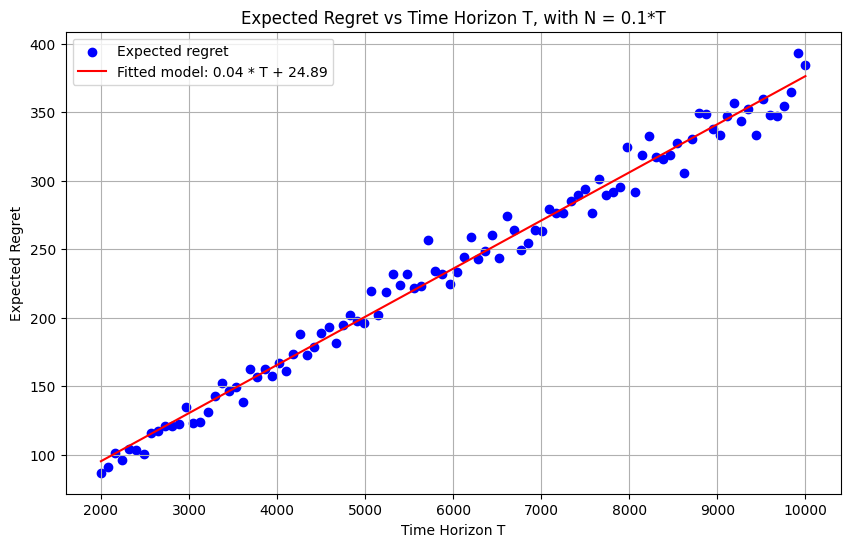

In [23]:
# This code block runs for ~10s.

importlib.reload(fe);

K = 5
T_values = np.linspace(2000, 10000, num=100, dtype=int)
mu = np.random.rand(K)  # Random means for each arm

# Compute average regrets for each T, with N = 0.1*T.
avg_regrets = []
for T in T_values:
    reg = fe.average_regret(K, T, mu, N=None, method='linear', num_runs=100)
    avg_regrets.append(reg)
avg_regrets = np.array(avg_regrets)

# Interpolation
# We expect regret ~ O(T), so we fit a line: avg_regret = a * T + b
coeffs = np.polyfit(T_values, avg_regrets, 1)
a, b = coeffs
fitted_regrets = a * T_values + b

plt.figure(figsize=(10, 6))
plt.scatter(T_values, avg_regrets, color='blue', label="Expected regret")
plt.plot(T_values, fitted_regrets, color='red', label=f"Fitted model: {a:.2f} * T + {b:.2f}")
plt.xlabel("Time Horizon T")
plt.ylabel("Expected Regret")
plt.title("Expected Regret vs Time Horizon T, with N = 0.1*T")
plt.grid(True)
plt.legend()
plt.show()

### Question 2

How should we choose the exploration parameter N?

What prior information about the MAB problem is needed? K? T? the optimality gaps $\Delta_i$?

K: With large K, we would need more exploration steps $N$ to get a reasonable sample average to choose the optimal arm. That is, N should be proportional to K.

T: N should obviously depend somehow on T; it can simply be a fraction of T or a function of T.

$\Delta$: During the exploratioin phase, we are adding roughly $\Delta$ to a regret per one exploration round, where $\Delta \in \{ \Delta_i \}_{i = 1, 2, \dots, K}$ is the 'typical' optimality gap. That is, the total regret in the exploration phase is about $N \Delta$, so information about the optimality gaps $\Delta_i$ helps to choose the exploration parameter $N$ which makes the total regret in the exploration phase smaller.


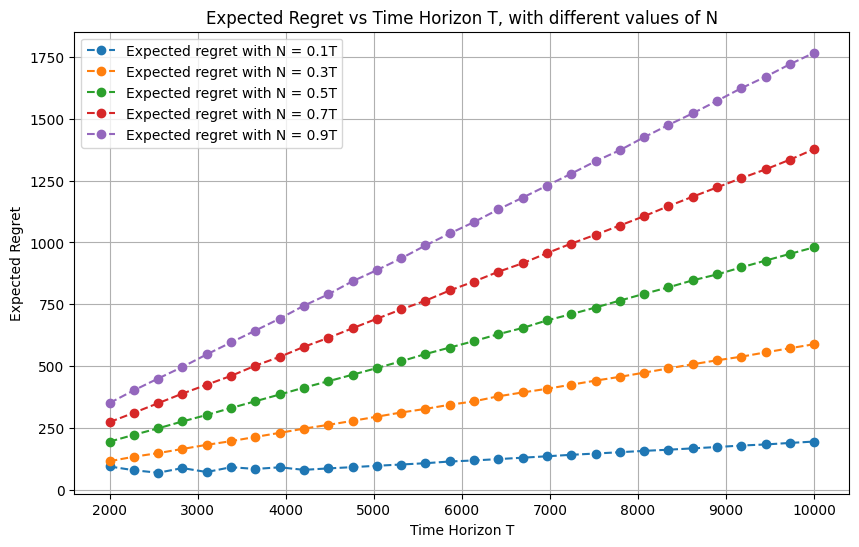

In [59]:
# Regret vs T for different values of N as a fraction of T.

# This code block runs for ~10s.

importlib.reload(fe);

K = 5
T_values = np.linspace(2000, 10000, num=30, dtype=int)
mu = np.random.rand(K)  # Random means for each arm

fractions = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10, 6))

# Compute average regrets for each K and N.
for frac in fractions:
    avg_regrets = []
    for T in T_values:
        N = int(frac * T)
        reg = fe.average_regret(K, T, mu, N=N, method='linear', num_runs=30)
        avg_regrets.append(reg)
    avg_regrets = np.array(avg_regrets)

    plt.plot(T_values, avg_regrets, 'o--', label=f"Expected regret with N = {frac}T")

plt.xlabel("Time Horizon T")
plt.ylabel("Expected Regret")
plt.title("Expected Regret vs Time Horizon T, with different values of N")
plt.grid(True)
plt.legend()
plt.show()

### Question 3

Find $N$, potentially as a function of $T$ and other parameters, such that the fixed exploration algorithm achiees sublinear expected regret in $T$.

During the exploration phase, each arm is pulled roughlly $n = N/K$ times since we choose arms uniformly at random. For any given arm $i$ with true mean $\mu_i$, let $\hat \mu_i$ be the sample mean after $n$ pulls. Then from Hoeffding's inequality

$$
\mathbb{P} (| \hat \mu_i - \mu_i| \ge \epsilon) \le 2 \exp(-2 \epsilon^2 n),
$$

we get

$$
\mathbb{P} (| \hat \mu_i - \mu_i| \ge \epsilon) \le 2 \exp(-2 \epsilon^2 \frac{N}{K}),
$$

for any $\epsilon > 0$.

Since we want that with high probability, the sample mean of each arm is within a small error of its true mean, set the probability of error for each arm to be at most $1/T$, i.e.

$$
\mathbb{P} (| \hat \mu_i - \mu_i| \ge \epsilon) \le 2 \exp(-2 \epsilon^2 \frac{N}{K}) \le \frac{1}{T}.
$$

Let $\Delta$ be the difference between the mean of the arm with the largest sample average, i.e. the best arm, and the mean of the arm with the second to the largest sample average, i.e. best suboptimal arm. In order to confidently distinguish the best arm from the best suboptimal arm, we need the estimation error to be less than $\Delta / 2$. That is, set $\epsilon = \Delta / 2$.

Then we have

$$
2 \exp\left(-2 \left( \frac{\Delta}{2} \right)^2 \frac{N}{K} \right) \le \frac{1}{T} \\
2 \exp\left(- \frac{\Delta^2}{2} \frac{N}{K} \right) \le \frac{1}{T} \\
\log 2 - \frac{\Delta^2}{2} \frac{N}{K} \le -\log T
$$

With large enough $T$, the constant $\log 2$ is negligible, so we have

$$
\frac{\Delta^2}{2} \frac{N}{K} \ge \log T
$$

and thus

$$
N \ge \frac{2K \log T}{\Delta^2}.
$$

Up to constant factors, choose $N \approx \frac{K \log T}{\Delta^2}$.

Then, since the regret in the exploration phase is proportional to $N$, the exploration regret grows as $O(\log T)$, i.e. sublinearly in $T$, and since we set that the probability of misidentifying the best arm is very small, on the order of $1/T$, the regret in the exploitation phase, which lasts $T-N$ steps, is $O(T \cdot 1/T) = O(1)$ which is negligible. That is, with $N \approx \frac{K \log T}{\Delta^2}$, the expected regret is sublinear in $T$.


Delta: 0.12132414307371886


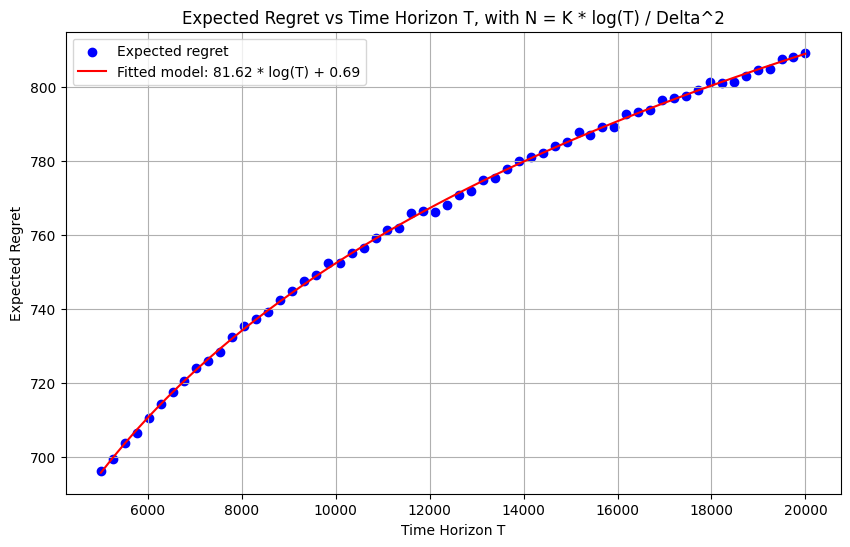

In [ ]:
# This code blocks runs for ~ 1min.

importlib.reload(fe);

K = 5
T_values = np.linspace(5000, 20000, num=60, dtype=int)
mu = np.random.rand(K)  # Random means for each arm

# If the Delta is too small (eg. < 0.1), the regret follow linear trend.
print('Delta:', np.max(mu) - np.sort(mu)[-2])

# Compute average regrets for each T, with N = K * log(T) / Delta^2.
avg_regrets = []
for T in T_values:
    reg = fe.average_regret(K, T, mu, N=None, method='sublinear', num_runs=150)
    avg_regrets.append(reg)
avg_regrets = np.array(avg_regrets)

# Interpolation
# We expect regret ~ O(log(T)), so we fit a line: avg_regret = a * log(T) + b
logT = np.log(T_values)
coeffs = np.polyfit(logT, avg_regrets, 1)
a, b = coeffs
fitted_regrets = a * logT + b

plt.figure(figsize=(10, 6))
plt.scatter(T_values, avg_regrets, color='blue', label="Expected regret")
plt.plot(T_values, fitted_regrets, color='red', label=f"Fitted model: {a:.2f} * log(T) + {b:.2f}")
plt.xlabel("Time Horizon T")
plt.ylabel("Expected Regret")
plt.title("Expected Regret vs Time Horizon T, with N = K * log(T) / Delta^2")
plt.grid(True)
plt.legend()
plt.show()